In [1]:
# radimo isti onaj primer sa mnist skupom samo preko konvolutivne mreze
from tensorflow.keras.datasets import mnist

In [2]:
(X_train, y_train) , (X_test, y_test) = mnist.load_data()
print(X_train.shape)

(60000, 28, 28)


In [3]:
#  nisam ispratio ovo za kanale, visi snimak
import keras.backend as K

In [4]:
img_size = X_train.shape[1]

# ulaz u mreze se ocekuje da bude 3d (?) zbog rgba kanala (?) 
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_size, img_size)
    X_test = X_test.reshape(X_test.shape[0], 1, img_size, img_size)
else:
    X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
    X_test = X_test.reshape(X_test.shape[0], img_size, img_size, 1)

print(X_train.shape)

(60000, 28, 28, 1)


In [5]:
# opet normalizujemo
X_train = X_train / 255
X_test = X_test / 255

In [6]:
print(y_train.shape)

(60000,)


In [7]:
from tensorflow.keras.utils import to_categorical

In [8]:
# isto kao prosli  put, hocemo da nam rezultati budu kategoricki
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(y_train.shape)

(60000, 10)


In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout   #konvolutivni sloj, koristimo ovaj 2D jer imamo slike, 

In [10]:
# hocemo da ulaz bude slika
input_shape = X_train.shape[1:]
print(input_shape)

(28, 28, 1)


In [11]:
model = Sequential()
# prvi arg je broj filtera koji se uci, kernel size je velicina fitlera. Genralno su filteri neparnih dimenzija#
# praksa je da se koriste male dimenzije filtera, jer ako je filter preveliki, previse ce se smanjiti dimenzija podataka
# na koju je filter primenjen. Bolje je da u tim situacijama umesto jednog elikog fitlera imamo 2 sloja sa po jednim manjim filterom (?)
# takodje ako imamo vise manjih filtera, vidi se da ce morati da se nauci manje tezina/parametara, npr jedan filter
# velicine 5x5 ima 25 tezina, a 2 3x3 fitlera imaju ukupno 9+9=18 parametara
# strides nam pomaze da se brze smanji dimenzija tako sto preskacemo neke pozicije za konvoluciju
# padding='same' kazemo da hocemo da dobijemo rezultat iste dimenzije kao polazna slika tako sto se 
# doda vestacki okvir oko polaznih podataka i onda konvolucija ne smanji dimenziju
# (opcija same dodaje okvir nula jer one ne kvare skalarni proizvodm, moze da se doda i neka druga vrednost, npr
# vrednost suseda)
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# dropout radi regularizaciju, hocemo da se izlazi iz 20% neurona do sad ignorise, da nebi overfitovao
# primetimo da dropout utice na podatke samo pri treningu, tj pri pravljenju mreze
# kada se pokrene evaluate, dropout nema nikakvog uticja na test podatke
model.add(Dropout(0.2))
# od matrice sa ovim flatten dobijamo vektor
model.add(Flatten())
# sad ulazimo u potpuno povezanu mrezu da bismo uradili klasifikaciju
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=num_classes, activation='softmax'))
model.summary()

# primetimo da je prednost konv. mreza sto imaju mnogo manje parametara koji se uvce u odnosu na guste

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# ovo izvrsavanje dugo traje i zato je koristio gpu na collab-u
history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 11s 28ms/step - loss: 0.4418 - accuracy: 0.8623 - val_loss: 0.0914 - val_accuracy: 0.9743
Epoch 2/10
375/375 [==============================] - 11s 28ms/step - loss: 0.1671 - accuracy: 0.9522 - val_loss: 0.0630 - val_accuracy: 0.9822
Epoch 3/10
375/375 [==============================] - 11s 28ms/step - loss: 0.1266 - accuracy: 0.9616 - val_loss: 0.0493 - val_accuracy: 0.9851
Epoch 4/10
375/375 [==============================] - 11s 28ms/step - loss: 0.1058 - accuracy: 0.9684 - val_loss: 0.0455 - val_accuracy: 0.9872
Epoch 5/10
375/375 [==============================] - 11s 28ms/step - loss: 0.0900 - accuracy: 0.9727 - val_loss: 0.0418 - val_accuracy: 0.9862
Epoch 6/10
375/375 [==============================] - 11s 29ms/step - loss: 0.0818 - accuracy: 0.9755 - val_loss: 0.0423 - val_accuracy: 0.9884
Epoch 7/10
375/375 [==============================] - 11s 29ms/step - loss: 0.0759 - accuracy: 0.9772 - val_loss: 0.0369 - val_accuracy:

In [14]:
from matplotlib import pyplot as plt

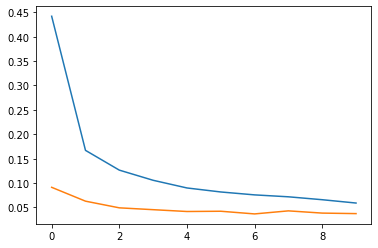

In [15]:
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])

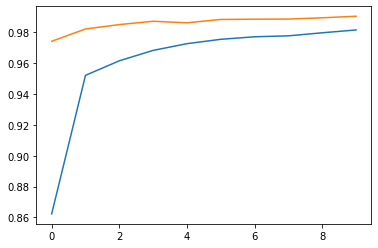

In [17]:
plt.plot(history.epoch, history.history['accuracy'])
plt.plot(history.epoch, history.history['val_accuracy'])

In [19]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0290 - accuracy: 0.9904


[0.0289843138307333, 0.9904000163078308]

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [29]:
y_true = np.argmax(y_test, axis=1)   # radimo unazad onaj to_categorical
print(y_true.shape)

y_pred = np.argmax(model.predict(X_test), axis=1)
print(y_pred.shape)

#matr konfuzije nam daje odnos stvarnih klsasa instanci i onih koje su predvidjene, podseti se sa IP
# vrste su predicted, kolone su stvarne vrednosti, na dijagonali treba da vidimo najvece brojeve
# jer su to instance koje su pravilno predvidjene
print(confusion_matrix(y_true, y_pred))

# ovaj daje rpeciznost, odziv, f1 itd
print(classification_report(y_true, y_pred))

(10000,)
(10000,)
[[ 973    0    1    0    1    1    2    1    1    0]
 [   0 1132    2    1    0    0    0    0    0    0]
 [   1    5 1021    0    1    0    0    3    1    0]
 [   0    0    0 1000    0    7    0    2    1    0]
 [   0    0    0    0  978    0    0    0    1    3]
 [   1    0    0    1    0  887    2    0    0    1]
 [   2    2    0    0    2    3  946    0    3    0]
 [   0    3    7    2    0    0    0 1015    1    0]
 [   2    1    2    0    2    1    1    2  961    2]
 [   0    3    0    0    5    5    0    3    2  991]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7      